## LSTM

Source: [https://cnvrg.io/pytorch-lstm/]

Basically a NN for sequential data.

You'll see below that for the testing data, the predicted stock prices aren't super accurate but the model identifies the trend of the stock pretty well.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable 
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
%load_ext autoreload
%autoreload 2
from lstm_model import LSTMModel

### Create Data

In [43]:
ticker = 'XOM'
start_date = '2014-01-01'
end_date = '2024-01-01'

# data = yf.download(ticker, start=start_date, end=end_date)
ticker_data = yf.Ticker(ticker)
data = ticker_data.history(start=start_date, end=end_date)

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# Calculate moving averages and std
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Std_Dev'] = data['Close'].rolling(window=20).std()

# Calculate the z-score
data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down

data['RSI'] = 100 - (100 / (1 + rs))

# Calculate TTM EPS and P/E
eps = ticker_data.get_earnings_dates(limit=60)
eps = eps[(eps.index >= (data.index[0]-relativedelta(years=1))) & (eps.index <= data.index[-1])]
eps = eps.iloc[::-1]
eps['TTM'] = eps['Reported EPS'].rolling(window=4).sum()
eps.index = eps.index.date
idx = pd.date_range(eps.index[0], eps.index[-1])
eps = eps.reindex(idx.date, fill_value=np.nan)
data.index = data.index.date
data['TTM_EPS'] = eps['TTM'].copy()
data[data['TTM_EPS'].notna()]
data['TTM_EPS'] = data['TTM_EPS'].ffill()
data['TTM_EPS'] = data['TTM_EPS'].fillna(eps['TTM'].loc[eps['TTM'].notna()].iloc[0])
data['TTM_P/E'] = data['Close'] / data['TTM_EPS']

# If stock price goes up or down
data['Target'] = data['Close'].shift(-1)

data.dropna(inplace=True)

# Wanted features for X and y
features = ['Close', 'Returns', 'SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'TTM_EPS', 'TTM_P/E']
X = data.loc[:, data.columns != 'Target']
y = data.iloc[:, (data.shape[1]-1):(data.shape[1])]

In [44]:
X.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,SMA_20,SMA_50,Std_Dev,Z_Score,RSI,TTM_EPS,TTM_P/E
2014-03-14,60.733148,61.148506,60.544939,60.661758,11723300,0.0,0.0,-0.001815,61.608629,61.664016,0.684106,-1.384098,44.303369,7.37,8.230903
2014-03-17,60.973260,61.349679,60.843462,61.213390,8676100,0.0,0.0,0.009094,61.615443,61.602641,0.679194,-0.591955,48.780837,7.37,8.305752
2014-03-18,61.271811,61.816966,61.051149,61.466507,8757300,0.0,0.0,0.004135,61.636211,61.549421,0.667277,-0.254323,50.737760,7.37,8.340096
2014-03-19,61.427547,61.849396,60.441069,60.830471,9914700,0.0,0.0,-0.010348,61.629072,61.481547,0.675457,-1.182313,45.983441,7.37,8.253795
2014-03-20,60.642251,61.485944,60.363182,61.382107,10405000,0.0,0.0,0.009068,61.603435,61.406533,0.674568,-0.328104,50.330562,7.37,8.328644


### Scale Data

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm = MinMaxScaler()
ss = StandardScaler()
ss1 = StandardScaler()
# mm2 = MinMaxScaler()
# ss2 = StandardScaler()

# X_ss = pd.DataFrame(ss.fit_transform(X), index=X.index, columns=X.columns)
# y_mm = pd.DataFrame(mm.fit_transform(y), index=y.index, columns=y.columns)

# Split data into first 80% and last 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
X_train_ss = pd.DataFrame(ss.fit_transform(X_train), index=X_train.index, columns=X.columns) # fit ss and transform X_train
y_train_mm = pd.DataFrame(ss1.fit_transform(y_train), index=y_train.index, columns=y.columns) # fit mm and transform y_train
X_test_ss = pd.DataFrame(ss.transform(X_test), index=X_test.index, columns=X.columns) # transform X_test with fitted ss
y_test_mm = pd.DataFrame(ss1.transform(y_test), index=y_test.index, columns=y.columns) # transform y_test with fitted mm

## Prepare Data for LSTM

Converts the Numpy Arrays to Tensors and to Variables (which can be differentiated).

In [46]:
features_ = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'TTM_P/E'] # Features to train with.
X_train_tensors = Variable(torch.Tensor(np.array(X_train_ss[features_])))
X_test_tensors = Variable(torch.Tensor(np.array(X_test_ss[features_])))

y_train_tensors = Variable(torch.Tensor(y_train_mm.values))
y_test_tensors = Variable(torch.Tensor(y_test_mm.values))

In [47]:
X_train_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [48]:
print("Training Shape", X_train_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([2219, 1, 7]) torch.Size([2219, 1])
Testing Shape torch.Size([247, 1, 7]) torch.Size([247, 1])


In [49]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [160]:
# train_dataset = SequenceDataset(
#     df_train_ss,
#     target='Target',
#     features=features_,
#     sequence_length=30
# )

In [161]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True)
# #test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [162]:
# X, y = next(iter(train_loader))

# print("Features shape:", X.shape)
# print("Target shape:", y.shape)

Features shape: torch.Size([6, 30, 8])
Target shape: torch.Size([6])


### Training

In [50]:
num_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_final.shape[2] # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
batch_size = X_train_tensors.shape[0]
window = 1

num_classes = 1 #number of output classes

In [51]:
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, seq_length=window, batch_size=batch_size) #our lstm class 

In [52]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # ADAM optimizer

In [165]:
# from custom_data_loader import MyDataset

In [52]:
# data_loader_train = torch.utils.data.DataLoader(
#     MyDataset((X_train_tensors, y_train_tensors), window),
#     batch_size=batch_size,
#     shuffle=False
# )

In [53]:
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_final, y_train_tensors),
    batch_size=batch_size,
    shuffle=False
)

In [54]:
for i, (X_, y_) in enumerate(data_loader_train):
    if i == 0:
        print(X_.size())
        print(y_.size())

torch.Size([2219, 1, 7])
torch.Size([2219, 1])


In [56]:
for epoch in range(num_epochs):
  for i, data in enumerate(data_loader_train):
    X_, y_ = data
    outputs = lstm.forward(X_) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = criterion(outputs, y_.reshape(y_.size(0)*y_.size(1), 1))
  
    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop
    # if (i + 1) % 50 == 0:
    #     print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.00170
Epoch: 100, loss: 0.02041
Epoch: 200, loss: 0.00778
Epoch: 300, loss: 0.00619
Epoch: 400, loss: 0.00580
Epoch: 500, loss: 0.00557
Epoch: 600, loss: 0.00543
Epoch: 700, loss: 0.00529
Epoch: 800, loss: 0.00513
Epoch: 900, loss: 0.00501


In [58]:
for i, (X_, y_) in enumerate(data_loader_train):
    if i == 0:
        train_predict = lstm(X_).data.numpy()
    else:
        train_predict = np.append(train_predict, lstm(X_).data.numpy(), axis=0)

In [60]:
# run these once
train_predict = ss1.inverse_transform(train_predict) # reverse transformation
X_train = pd.DataFrame(ss.inverse_transform(X_train_ss), index=X_train_ss.index, columns=X_train_ss.columns) # reverse transformation for training data

In [61]:
predicted_price = pd.DataFrame(train_predict)
predicted_price.columns = ['Predicted_Price']
predicted_price.size
idx = X_train.index[:predicted_price.size]
predicted_price.index = idx
X_train = pd.concat([X_train, predicted_price], ignore_index=False, axis=1)
X_train = X_train.dropna()

Accuracy: 0.9761153672825598


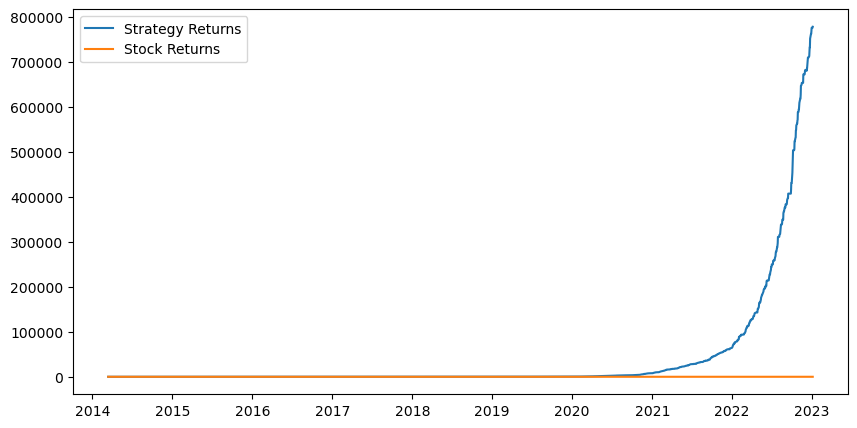

In [62]:
#X_train['Predicted_Price'] = data_predict
X_train['Actual_Signal'] = (X_train['Returns'].shift(-1) > 0).astype(int) # actual signal, 1 if next-day returns > 0, 0 if next-day returns <= 0
X_train['Predicted_Returns'] = X_train['Predicted_Price'].pct_change() # calculate returns of predicted stock price
X_train['Predicted_Signal'] = (X_train['Predicted_Returns'].shift(-1) > 0).astype(int) # predicted signal based on predicted returns
X_train['Strategy_Returns'] = X_train['Returns'] * X_train['Predicted_Signal'].shift(1) # strategy returns
cumulative_strategy_returns = (X_train['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_train.loc[X_train.index, 'Returns']
returns.iloc[0] = 0 # set the first actual return to 0 to ensure that both plots start at 1.
cumulative_stock_returns = (returns + 1).cumprod() # returns of the stock (basically if we held the stock for the entire duration)
accuracy = (X_train['Actual_Signal'] == X_train['Predicted_Signal']).mean() # accuracy of predicted signal
print(f'Accuracy: {accuracy}')

plt.figure(figsize=(10,5))
plt.plot(cumulative_strategy_returns, label='Strategy Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.legend();

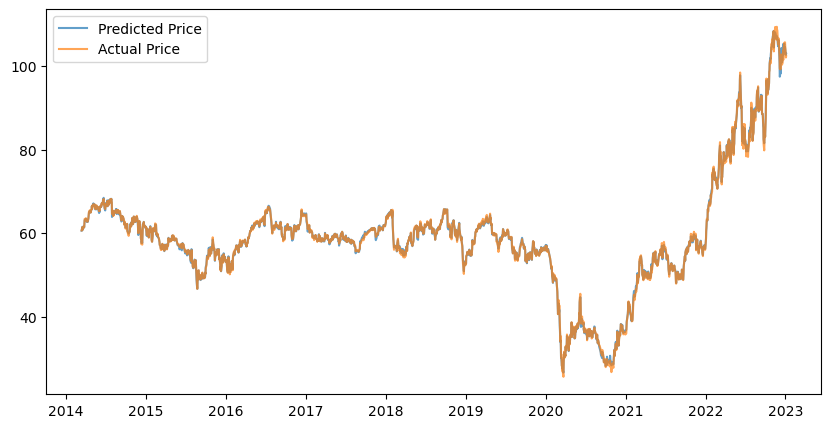

In [63]:
plt.figure(figsize=(10,5))
plt.plot(X_train['Predicted_Price'], label='Predicted Price', alpha=0.7)
plt.plot(X_train['Close'], label='Actual Price', alpha=0.7)
plt.legend();

In [64]:
test_predict = lstm(X_test_final).data.numpy()

In [65]:
test_predict = ss1.inverse_transform(test_predict)
X_test = pd.DataFrame(ss.inverse_transform(X_test_ss), index=X_test_ss.index, columns=X_test_ss.columns)

In [66]:
predicted_price = pd.DataFrame(test_predict)
predicted_price.columns = ['Predicted_Price']
predicted_price.size
idx = X_test.index[:predicted_price.size]
predicted_price.index = idx
X_test = pd.concat([X_test, predicted_price], ignore_index=False, axis=1)
X_test = X_test.dropna()

Accuracy: 0.8785425101214575


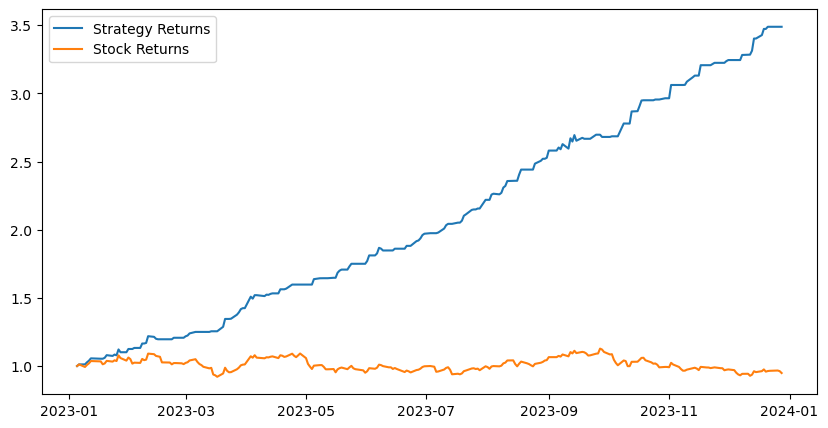

In [67]:
X_test['Actual_Signal'] = (X_test['Returns'].shift(-1) > 0).astype(int)
#X_test['Predicted_Price'] = data_predict
X_test['Predicted_Returns'] = X_test['Predicted_Price'].pct_change()
X_test['Predicted_Signal'] = (X_test['Predicted_Returns'].shift(-1) > 0).astype(int)
X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_test['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_test.loc[X_test.index, 'Returns']
returns.iloc[0] = 0
cumulative_stock_returns = (returns + 1).cumprod()
accuracy = (X_test['Actual_Signal'] == X_test['Predicted_Signal']).mean()
print(f'Accuracy: {accuracy}')
# Calculate cumulative returns for the market
#market_data['Returns'] = market_data['Close'].pct_change()
#cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

plt.figure(figsize=(10,5))

plt.plot(cumulative_strategy_returns, label='Strategy Returns')
#plt.plot(cumulative_market_returns, label='Market Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.legend();

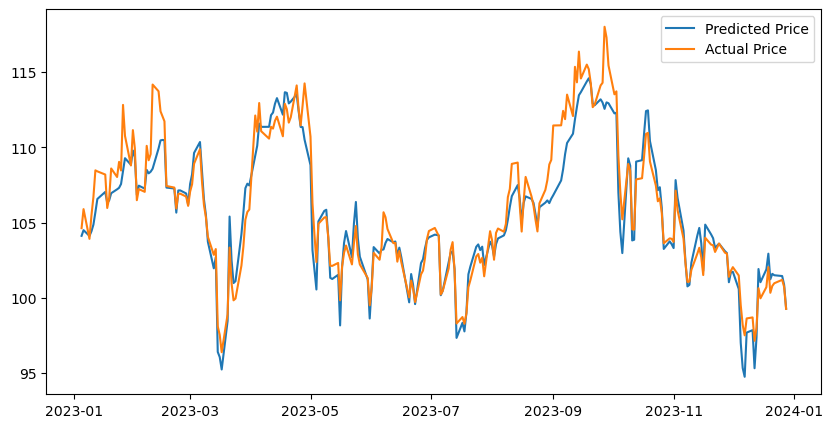

In [68]:
plt.figure(figsize=(10,5))
plt.plot(X_test['Predicted_Price'], label='Predicted Price')
plt.plot(X_test['Close'], label='Actual Price')
plt.legend();

In [22]:
from torchinfo import summary

In [180]:
summary(lstm)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              5,248
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       4,224
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       129
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0

## LSTM on 10 Biggest Energy Companies

In [3]:
tickers = ['XOM', 'CVX', 'COP', 'NEE', 'SO', 'EOG', 'DUK', 'MPC', 'SLB', 'PSX']

In [4]:
from lstm_data import prepare_data

In [14]:
# preps data, see lstm_data.py, prints size of each ticker's dataset
X_train, y_train, X_test, y_test, ss, mm, batch_size = prepare_data(tickers, start_date = '2014-01-01', end_date = '2024-01-01')

(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)


In [6]:
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'TTM_P/E']

X_train_tensors = Variable(torch.Tensor(np.array(X_train[features])))
y_train_tensors = Variable(torch.Tensor(y_train.values))
X_train_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

In [7]:
# split data by ticker
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_final, y_train_tensors),
    batch_size=batch_size,
    shuffle=True
)

In [8]:
num_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_final.shape[2] # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
batch_size = batch_size
window = 1 # number of windows, leave at 1, basically can ignore

num_classes = 1 # number of output classes

In [9]:
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, seq_length=window, batch_size=batch_size) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # ADAM optimizer

**Below takes about 7 min to run.**

In [10]:
for epoch in range(num_epochs):
  for i, data in enumerate(data_loader_train):
    X_, y_ = data
    outputs = lstm.forward(X_) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = criterion(outputs, y_.reshape(y_.size(0)*y_.size(1), 1))
  
    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop
    # if (i + 1) % 50 == 0:
    #     print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.87628
Epoch: 100, loss: 0.00447
Epoch: 200, loss: 0.00457
Epoch: 300, loss: 0.00452
Epoch: 400, loss: 0.00453
Epoch: 500, loss: 0.00461
Epoch: 600, loss: 0.00447
Epoch: 700, loss: 0.00439
Epoch: 800, loss: 0.00426
Epoch: 900, loss: 0.00443


In [28]:
def evaluate_lstm(model, X_test, y_test, ss, mm, features):
    ticker = X_test['Ticker'].iloc[0] # get ticker
    X_test_tensors = Variable(torch.Tensor(np.array(X_test[features]))) # prepare for lstm
    X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) # prepare for lstm

    test_predict = model(X_test_final).data.numpy() # predict
    test_predict = mm.inverse_transform(test_predict) # reverse transform back to original scale
    cols = X_test.columns[X_test.columns != 'Ticker']
    X_test = pd.DataFrame(ss.inverse_transform(X_test[cols]), index=X_test.index, columns=cols) # reverse transform X_test back to og scale
    predicted_price = pd.DataFrame(test_predict)
    predicted_price.columns = ['Predicted_Price']
    predicted_price.size
    idx = X_test.index[:predicted_price.size]
    predicted_price.index = idx # fix index of predicted prices
    X_test = pd.concat([X_test, predicted_price], ignore_index=False, axis=1) 
    X_test = X_test.dropna()
    X_test['Actual_Signal'] = (X_test['Returns'].shift(-1) > 0).astype(int) # actual buy/sell signal based on daily returns
    X_test['Predicted_Returns'] = X_test['Predicted_Price'].pct_change()
    X_test['Predicted_Signal'] = (X_test['Predicted_Returns'] > 0)*1 # predicted buy/sell signal based on predicted returns
    X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1) # calculate daily strategy returns
    cumulative_strategy_returns = (X_test['Strategy_Returns'].fillna(0) + 1).cumprod()
    returns = X_test.loc[X_test.index, 'Returns']
    returns.iloc[0] = 0
    cumulative_stock_returns = (returns + 1).cumprod()
    accuracy = (X_test['Actual_Signal'] == X_test['Predicted_Signal']).mean()
    print(f'{ticker} Accuracy: {accuracy}')

    # plot returns
    plt.figure(figsize=(10,5))
    plt.plot(cumulative_strategy_returns, label='Strategy Returns')
    plt.plot(cumulative_stock_returns, label='Stock Returns')
    plt.title(f'{ticker} Returns')
    plt.legend();

    # plot stock price
    plt.figure(figsize=(10,5))
    plt.plot(X_test['Predicted_Price'].shift(1), label='Predicted Price')
    plt.plot(X_test['Close'], label='Actual Price')
    plt.title(f'{ticker} Price')
    plt.legend();
    return X_test

XOM Accuracy: 0.5222672064777328


,Close,Predicted_Price,Actual_Signal,Predicted_Signal
2023-01-05,104.632027,103.781647,1,0
2023-01-06,105.896698,104.587227,0,1
2023-01-09,103.923058,103.350296,1,0
2023-01-10,105.475136,104.214096,1,1
2023-01-11,106.701500,105.119675,1,1
...,...,...,...,...
2023-12-21,100.793266,100.601486,1,1
2023-12-22,100.971611,100.547417,1,0
2023-12-26,101.199486,100.571609,0,1
2023-12-27,100.723907,99.989052,0,0


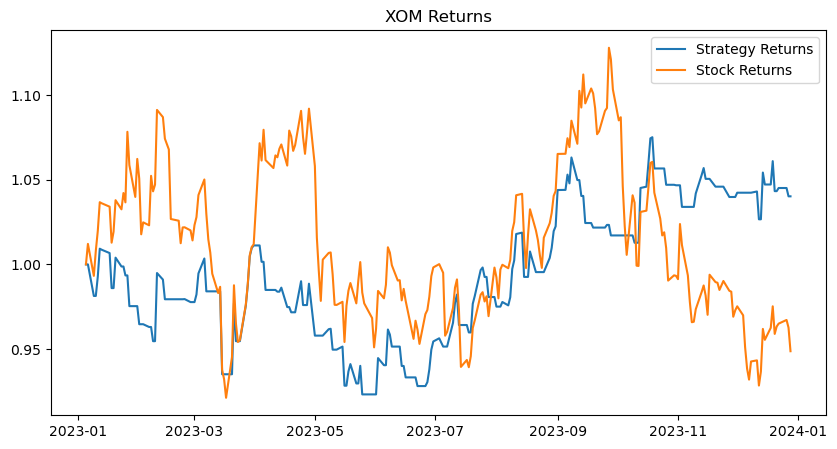

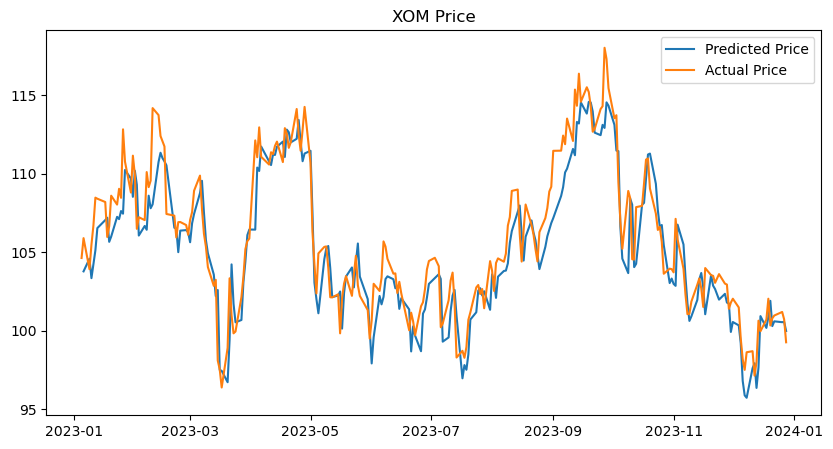

In [29]:
X_test0 = evaluate_lstm(lstm, X_test[0], y_test[0], ss[0], mm[0], features)
X_test0[['Close', 'Predicted_Price', 'Actual_Signal', 'Predicted_Signal']]

XOM Accuracy: 0.5222672064777328
CVX Accuracy: 0.5101214574898786
COP Accuracy: 0.4979757085020243
NEE Accuracy: 0.5020242914979757
SO Accuracy: 0.5465587044534413
EOG Accuracy: 0.5141700404858299
DUK Accuracy: 0.5425101214574899
MPC Accuracy: 0.5263157894736842
SLB Accuracy: 0.5222672064777328
PSX Accuracy: 0.5344129554655871


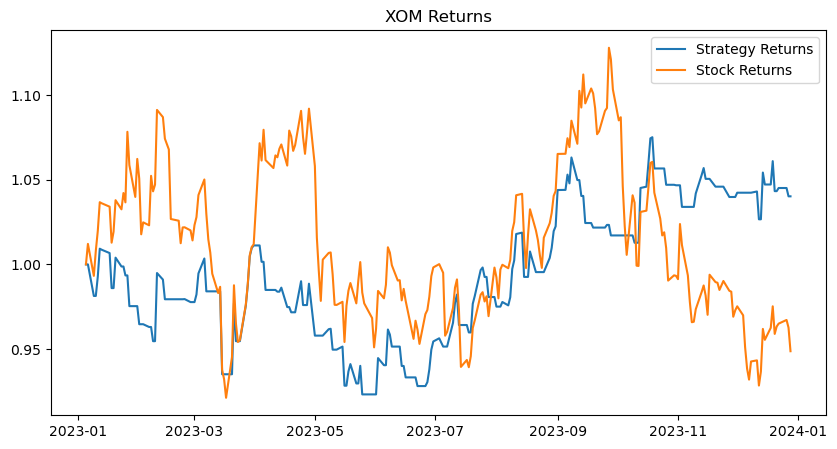

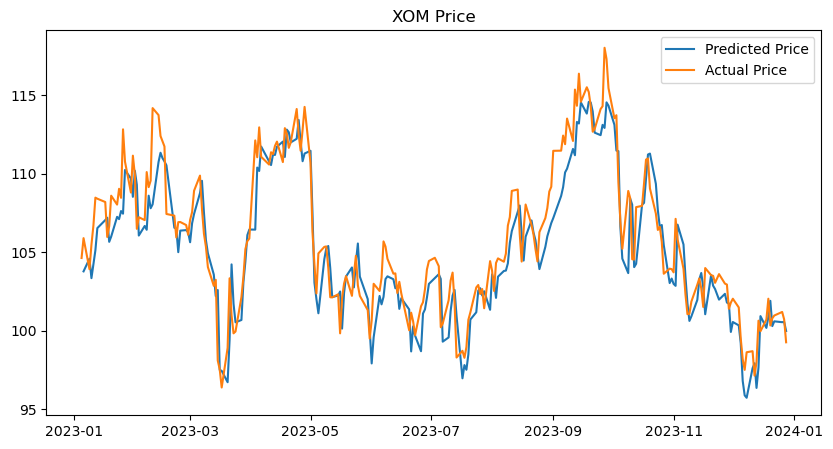

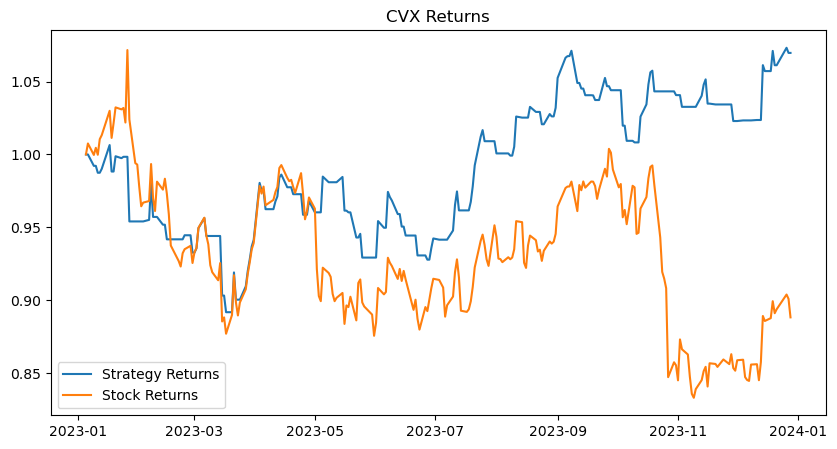

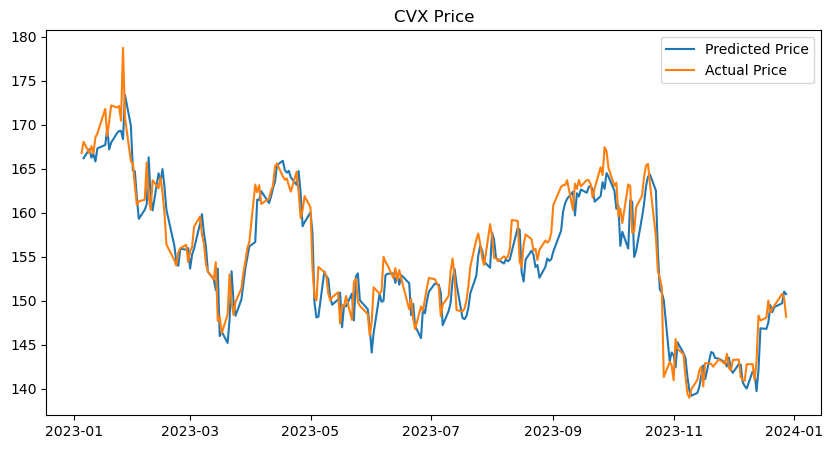

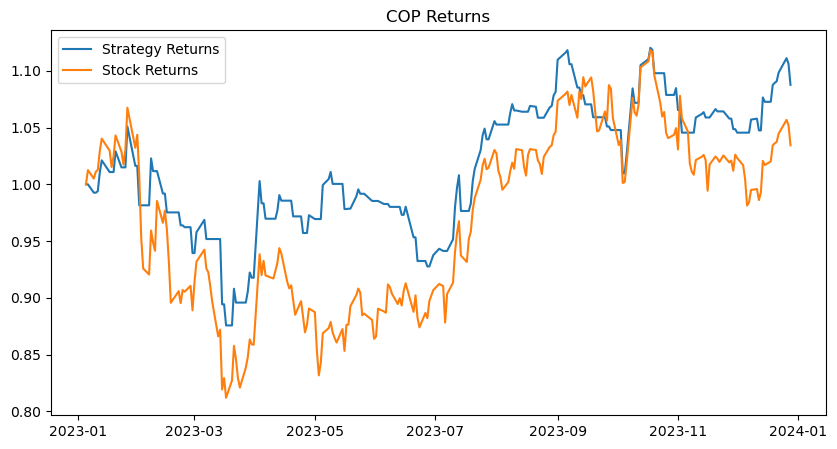

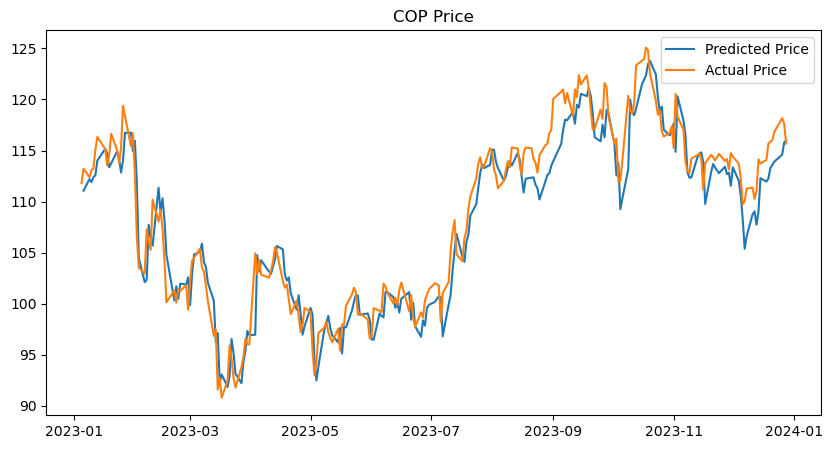

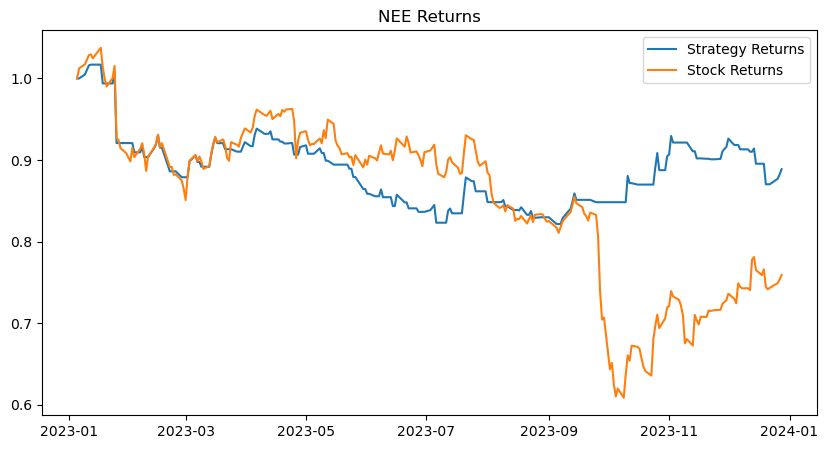

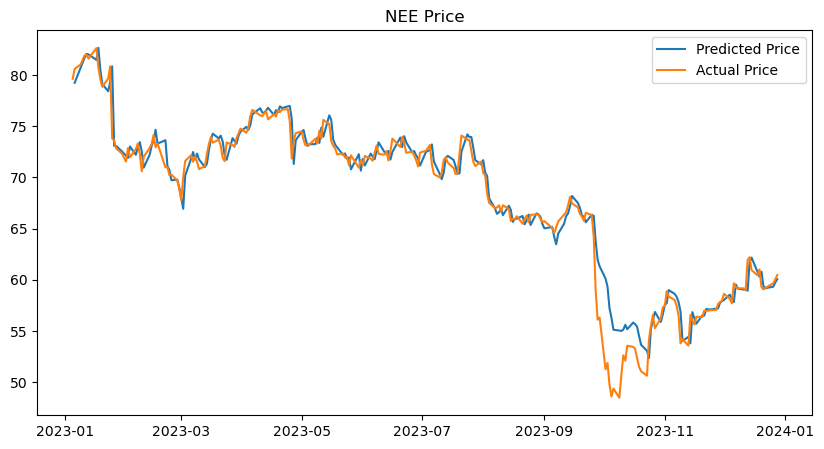

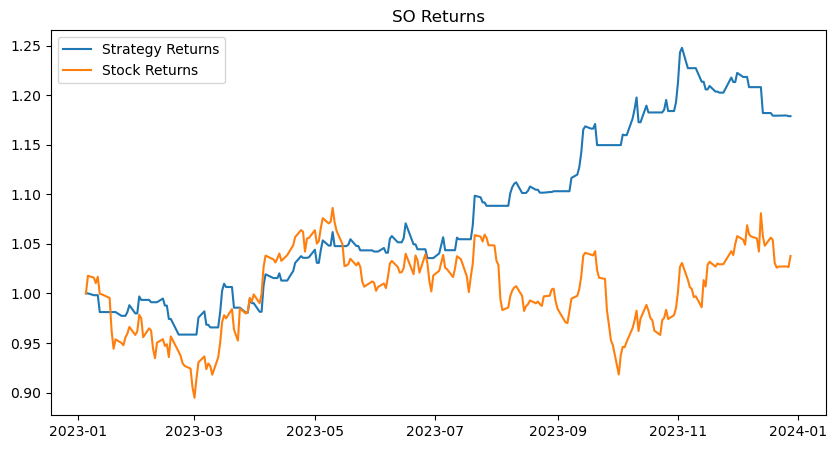

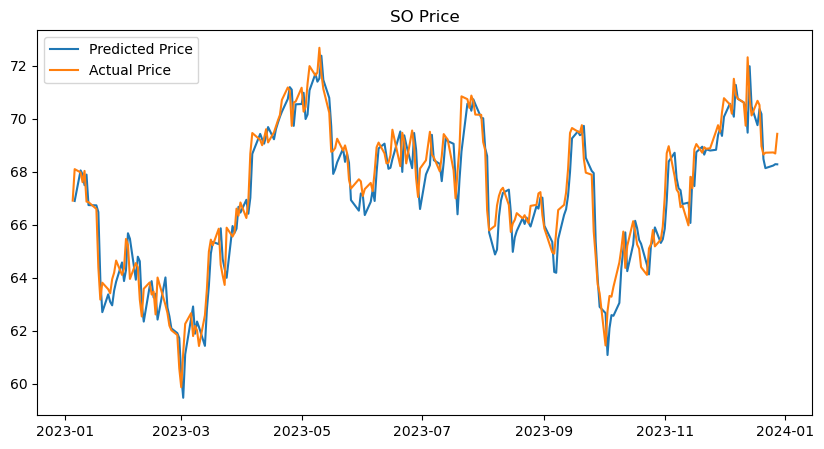

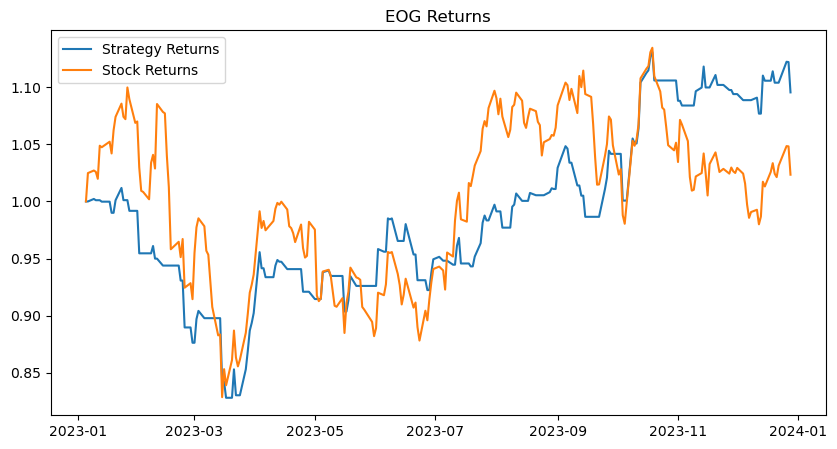

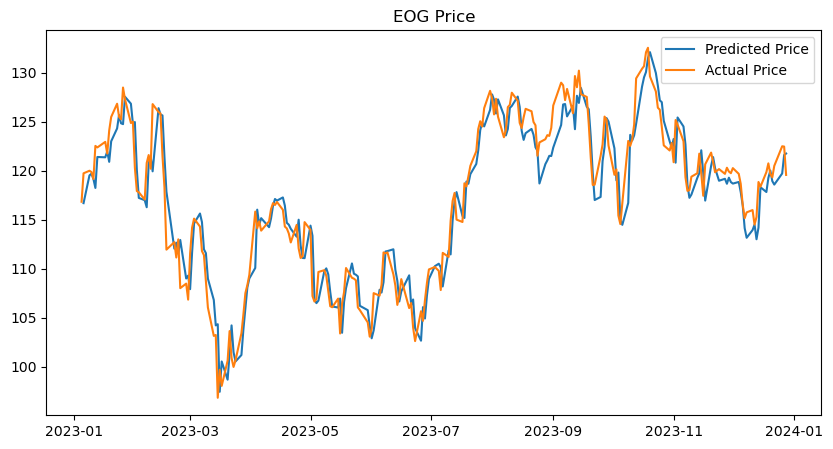

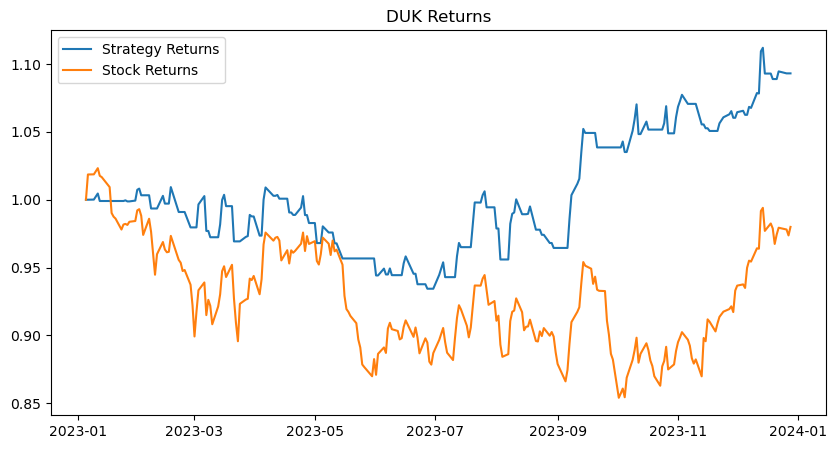

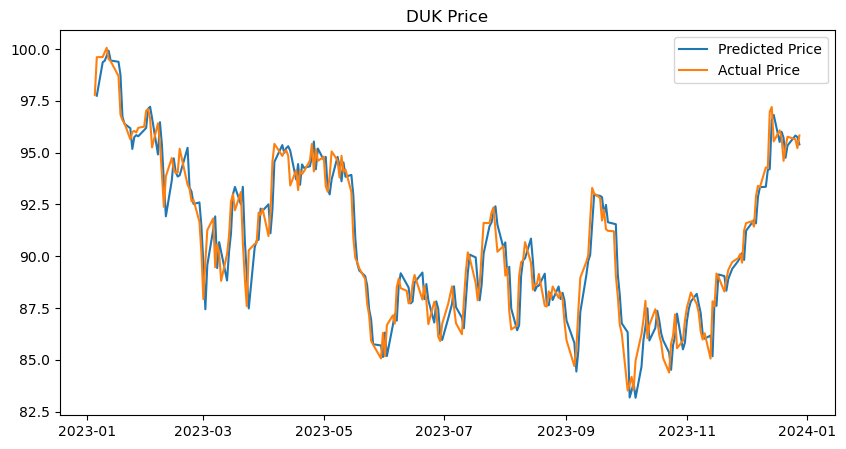

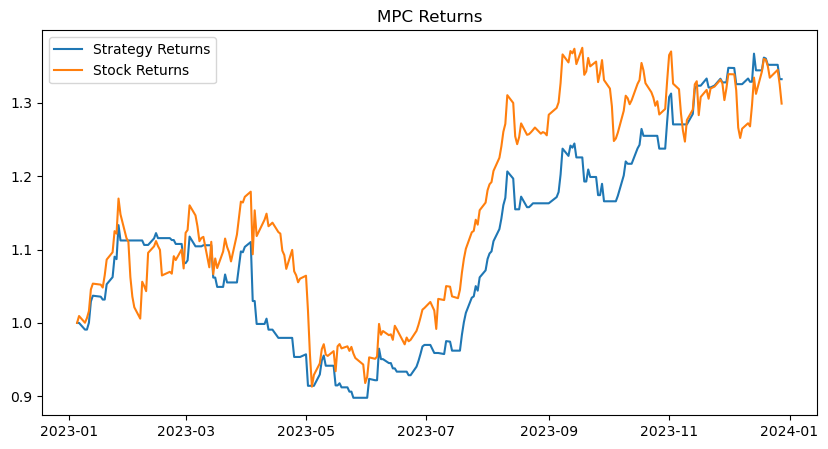

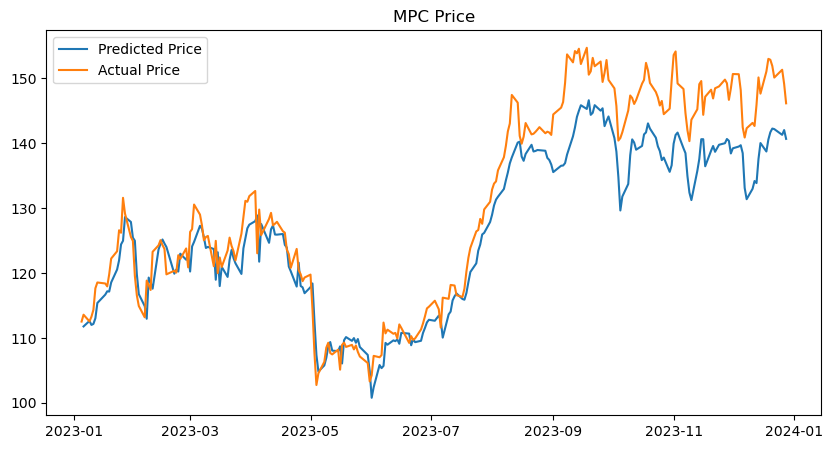

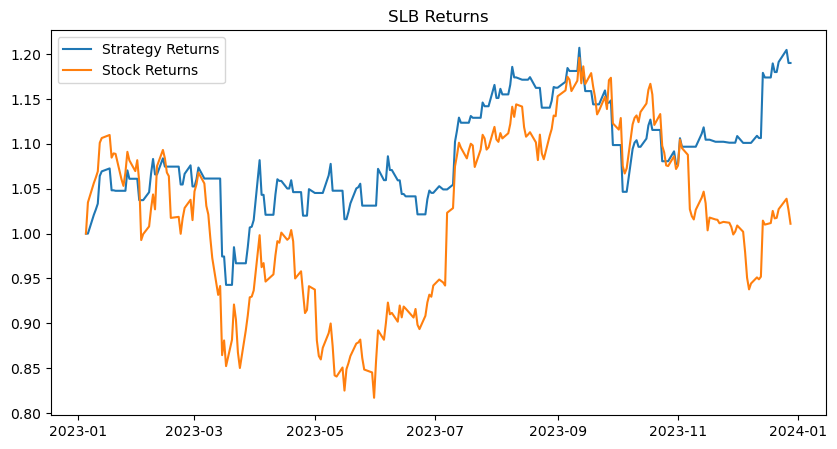

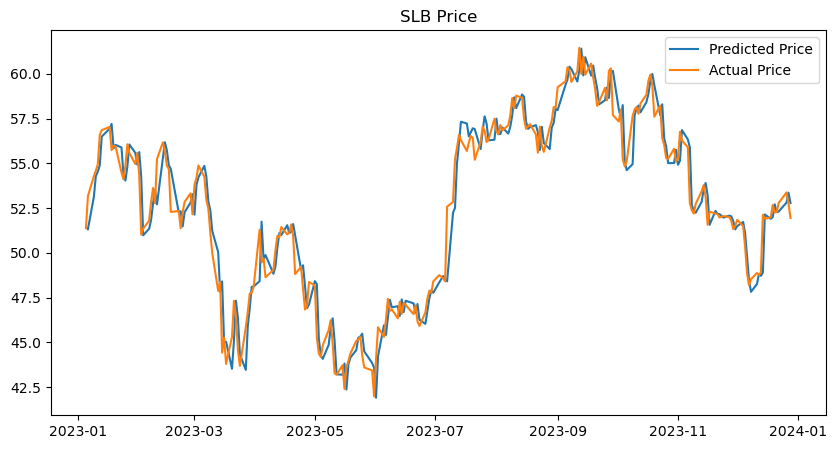

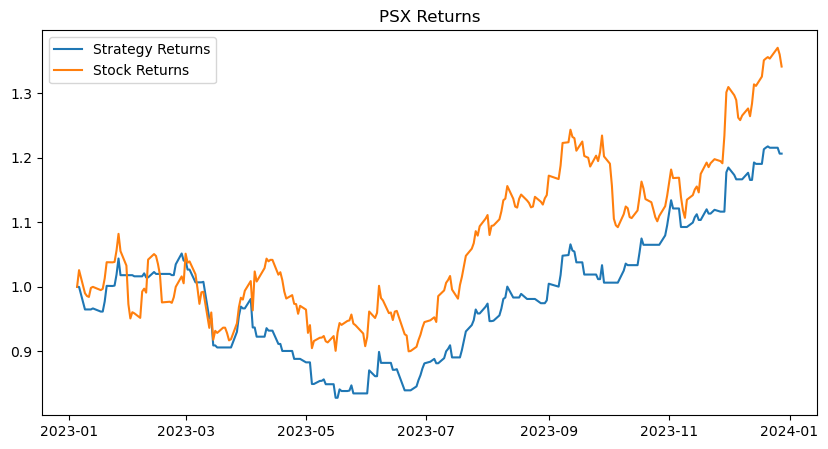

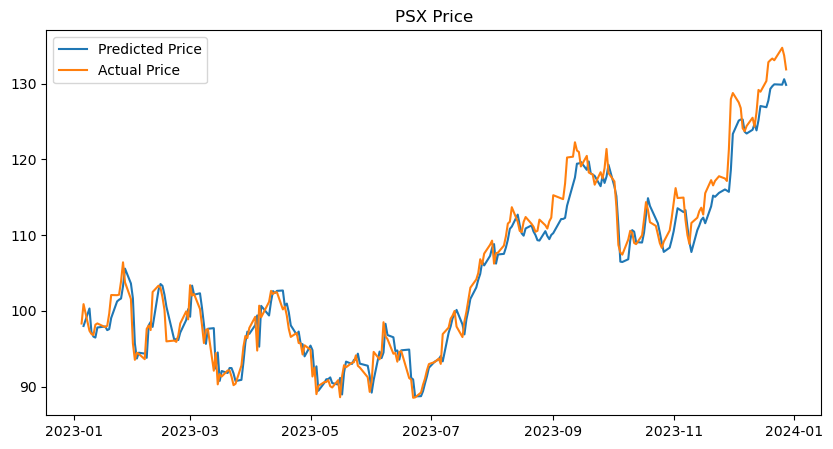

In [30]:
for i in range(10):
    evaluate_lstm(lstm, X_test[i], y_test[i], ss[i], mm[i], features)

## Further Testing

Note: need to test by combining training and test sets due to the nature of sequential data.

Accuracy: 0.7530364372469636


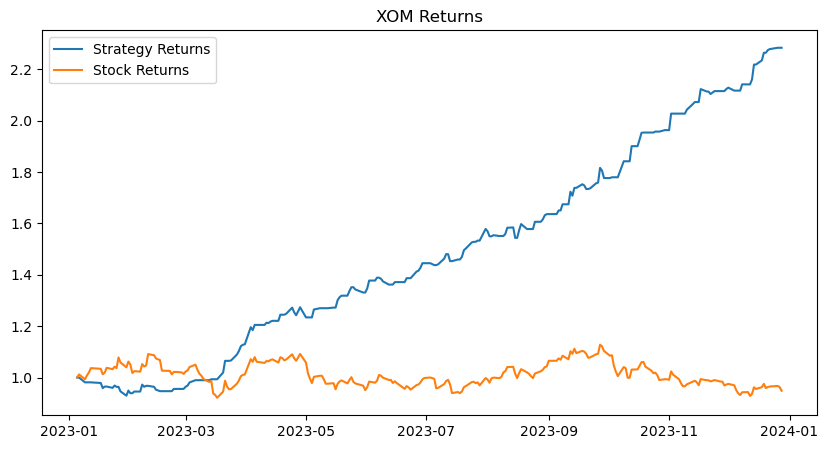

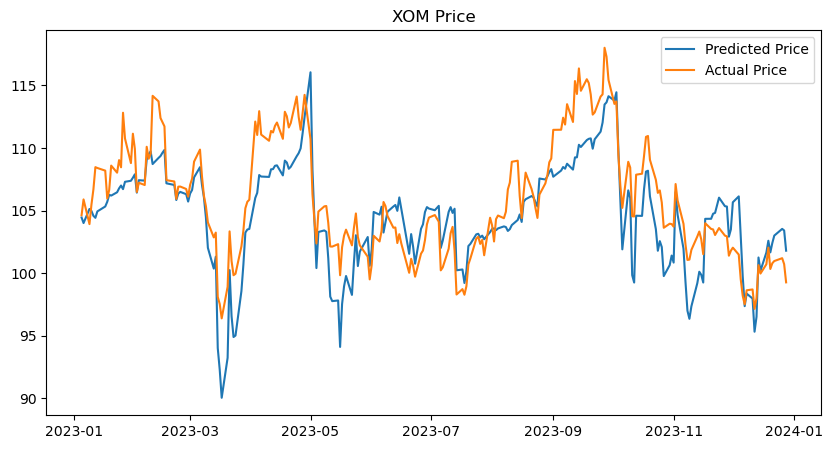

In [40]:
i = 0

ticker = X_test[i]['Ticker'].iloc[0]
X_test_tensors = Variable(torch.Tensor(np.array(X_test[i][features]))) # prepare for lstm
X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) # prepare for lstm

test_predict = lstm(X_test_final).data.numpy() # predict
test_predict = mm_scalers[i].inverse_transform(test_predict) # reverse transform back to original scale
cols = X_test[i].columns[X_test[i].columns != 'Ticker']
X_test_ = pd.DataFrame(ss_scalers[i].inverse_transform(X_test[i][cols]), index=X_test[i].index, columns=cols)
predicted_price = pd.DataFrame(test_predict)
predicted_price.columns = ['Predicted_Price']
predicted_price.size
idx = X_test_.index[:predicted_price.size]
predicted_price.index = idx
X_test_ = pd.concat([X_test_, predicted_price], ignore_index=False, axis=1)
X_test_ = X_test_.dropna()
X_test_['Actual_Signal'] = (X_test_['Returns'].shift(-1) > 0).astype(int)
#X_test['Predicted_Price'] = data_predict
X_test_['Predicted_Returns'] = X_test_['Predicted_Price'].pct_change()
X_test_['Predicted_Signal'] = (X_test_['Predicted_Returns'].shift(-1) > 0).astype(int)
X_test_['Strategy_Returns'] = X_test_['Returns'] * X_test_['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_test_['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_test_.loc[X_test_.index, 'Returns']
returns.iloc[0] = 0
cumulative_stock_returns = (returns + 1).cumprod()
accuracy = (X_test_['Actual_Signal'] == X_test_['Predicted_Signal']).mean()
print(f'Accuracy: {accuracy}')
# Calculate cumulative returns for the market
#market_data['Returns'] = market_data['Close'].pct_change()
#cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cumulative_strategy_returns, label='Strategy Returns')
#plt.plot(cumulative_market_returns, label='Market Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.title(f'{ticker} Returns')
plt.legend();

# plot stock price
plt.figure(figsize=(10,5))
plt.plot(X_test_['Predicted_Price'], label='Predicted Price')
plt.plot(X_test_['Close'], label='Actual Price')
plt.title(f'{ticker} Price')
plt.legend();

In [48]:
summary(lstm)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              5,248
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       4,224
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       129
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0

In [108]:
X_list = []
for X_, y_ in data_loader_train:
    X_list.append(X_)
X1 = pd.concat([X_train.iloc[:batch_size,:], X_test[0]])
ticker = X1['Ticker'].iloc[0]
# X1 = X_test[0]

In [109]:
i = 0

In [110]:
X_test_tensors = Variable(torch.Tensor(np.array(X1[features]))) # prepare for lstm
X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) # prepare for lstm

test_predict = lstm(X_test_final).data.numpy() # predict
test_predict = mm_scalers[i].inverse_transform(test_predict) # reverse transform back to original scale
cols = X1.columns[X_test[i].columns != 'Ticker']
X_test_ = pd.DataFrame(ss_scalers[i].inverse_transform(X1[cols]), index=X1.index, columns=cols)
predicted_price = pd.DataFrame(test_predict)
predicted_price.columns = ['Predicted_Price']
predicted_price.size
idx = X_test_.index[:predicted_price.size]
predicted_price.index = idx
X_test_ = pd.concat([X_test_, predicted_price], ignore_index=False, axis=1)
X_test_ = X_test_.dropna()

In [111]:
X_test_

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,SMA_50,Std_Dev,Z_Score,RSI,TTM_EPS,TTM_P/E,Returns,Predicted_Price
2014-03-14,60.733148,61.148506,60.544939,60.661758,11723300.0,0.0,0.0,61.608636,61.664019,0.684117,-1.384087,44.303418,7.37,8.230903,-0.001815,57.683525
2014-03-17,60.973264,61.349683,60.843466,61.213394,8676100.0,0.0,0.0,61.615450,61.602643,0.679205,-0.591951,48.780818,7.37,8.305752,0.009094,58.606907
2014-03-18,61.271811,61.816966,61.051149,61.466507,8757300.0,0.0,0.0,61.636220,61.549423,0.667287,-0.254332,50.737673,7.37,8.340096,0.004135,58.927059
2014-03-19,61.427551,61.849400,60.441073,60.830475,9914700.0,0.0,0.0,61.629080,61.481549,0.675467,-1.182302,45.983474,7.37,8.253796,-0.010348,58.022343
2014-03-20,60.642266,61.485959,60.363197,61.382122,10405000.0,0.0,0.0,61.603444,61.406536,0.674578,-0.328089,50.330605,7.37,8.328646,0.009069,58.783268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,100.535658,101.070687,99.881732,100.793266,19250900.0,0.0,0.0,100.424687,103.165610,1.916560,0.192313,48.493679,10.44,9.654527,0.004542,102.408745
2023-12-22,101.367922,101.992126,100.882436,100.971611,12921800.0,0.0,0.0,100.292912,103.094368,1.771334,0.383157,49.168148,10.44,9.671610,0.001769,103.004120
2023-12-26,101.793959,102.081290,101.179673,101.199486,16835100.0,0.0,0.0,100.202750,102.960920,1.669085,0.597175,50.067858,10.44,9.693437,0.002257,103.541283
2023-12-27,101.100406,101.605712,100.406847,100.723907,14558800.0,0.0,0.0,100.091782,102.816389,1.546573,0.408727,48.152305,10.44,9.647884,-0.004699,103.415825
